Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3326, Val size: 713, Test size: 713
Mean: [0.05387205 0.05387205 0.05387205]
Std: [0.23210354 0.23210354 0.23210354]
Using Custom Improved CNN
Model parameters: 8,242,185
Class weights: tensor([1.1441, 1.2876, 1.2570, 0.6683, 1.0650, 1.0559, 0.5730, 1.6647, 1.2117],
       device='cuda:0')

Starting training...


Epoch 1/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.42it/s, acc=0.137, loss=2.15]


Epoch 1/20 | Train Loss: 2.4447 | Train Acc: 0.1428 | Val Loss: 2.1482 | Val Acc: 0.1374
✓ Best model saved with val_acc: 0.1374


Epoch 2/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.97it/s, acc=0.158, loss=2.15]


Epoch 2/20 | Train Loss: 2.1865 | Train Acc: 0.1476 | Val Loss: 2.1478 | Val Acc: 0.1585
✓ Best model saved with val_acc: 0.1585


Epoch 3/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.78it/s, acc=0.233, loss=2.14]


Epoch 3/20 | Train Loss: 2.1760 | Train Acc: 0.1825 | Val Loss: 2.1373 | Val Acc: 0.2328
✓ Best model saved with val_acc: 0.2328


Epoch 4/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 23.38it/s, acc=0.233, loss=2.14]


Epoch 4/20 | Train Loss: 2.1536 | Train Acc: 0.1726 | Val Loss: 2.1407 | Val Acc: 0.2328


Epoch 5/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 22.96it/s, acc=0.261, loss=2.08]


Epoch 5/20 | Train Loss: 2.1254 | Train Acc: 0.2069 | Val Loss: 2.0774 | Val Acc: 0.2609
✓ Best model saved with val_acc: 0.2609


Epoch 6/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 23.11it/s, acc=0.192, loss=2.2] 


Epoch 6/20 | Train Loss: 2.1179 | Train Acc: 0.1870 | Val Loss: 2.1971 | Val Acc: 0.1921


Epoch 7/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 23.26it/s, acc=0.238, loss=2.01]


Epoch 7/20 | Train Loss: 2.0984 | Train Acc: 0.1846 | Val Loss: 2.0128 | Val Acc: 0.2384


Epoch 8/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.84it/s, acc=0.189, loss=2.03]


Epoch 8/20 | Train Loss: 2.1141 | Train Acc: 0.1840 | Val Loss: 2.0324 | Val Acc: 0.1893


Epoch 9/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.34it/s, acc=0.21, loss=2.08] 


Epoch 9/20 | Train Loss: 2.0803 | Train Acc: 0.1912 | Val Loss: 2.0816 | Val Acc: 0.2104


Epoch 10/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.00it/s, acc=0.309, loss=1.95]


Epoch 10/20 | Train Loss: 2.0137 | Train Acc: 0.2041 | Val Loss: 1.9467 | Val Acc: 0.3086
✓ Best model saved with val_acc: 0.3086


Epoch 11/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.18it/s, acc=0.321, loss=1.94]


Epoch 11/20 | Train Loss: 1.9803 | Train Acc: 0.2186 | Val Loss: 1.9360 | Val Acc: 0.3212
✓ Best model saved with val_acc: 0.3212


Epoch 12/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.65it/s, acc=0.229, loss=1.96]


Epoch 12/20 | Train Loss: 1.9225 | Train Acc: 0.2811 | Val Loss: 1.9578 | Val Acc: 0.2286


Epoch 13/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.23it/s, acc=0.405, loss=1.78]


Epoch 13/20 | Train Loss: 1.9048 | Train Acc: 0.2811 | Val Loss: 1.7762 | Val Acc: 0.4053
✓ Best model saved with val_acc: 0.4053


Epoch 14/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.54it/s, acc=0.384, loss=1.81]


Epoch 14/20 | Train Loss: 1.8642 | Train Acc: 0.2943 | Val Loss: 1.8146 | Val Acc: 0.3843


Epoch 15/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.20it/s, acc=0.419, loss=1.65]


Epoch 15/20 | Train Loss: 1.8331 | Train Acc: 0.3187 | Val Loss: 1.6460 | Val Acc: 0.4194
✓ Best model saved with val_acc: 0.4194


Epoch 16/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.48it/s, acc=0.411, loss=1.69]


Epoch 16/20 | Train Loss: 1.8157 | Train Acc: 0.3292 | Val Loss: 1.6910 | Val Acc: 0.4109


Epoch 17/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 25.34it/s, acc=0.419, loss=1.65]


Epoch 17/20 | Train Loss: 1.7724 | Train Acc: 0.3617 | Val Loss: 1.6481 | Val Acc: 0.4194


Epoch 18/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.63it/s, acc=0.471, loss=1.61]


Epoch 18/20 | Train Loss: 1.7665 | Train Acc: 0.3590 | Val Loss: 1.6148 | Val Acc: 0.4712
✓ Best model saved with val_acc: 0.4712


Epoch 19/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.66it/s, acc=0.48, loss=1.62] 


Epoch 19/20 | Train Loss: 1.7440 | Train Acc: 0.3957 | Val Loss: 1.6163 | Val Acc: 0.4797
✓ Best model saved with val_acc: 0.4797


Epoch 20/20 [Val]: 100%|██████████| 45/45 [00:01<00:00, 24.17it/s, acc=0.508, loss=1.59]


Epoch 20/20 | Train Loss: 1.7057 | Train Acc: 0.4059 | Val Loss: 1.5929 | Val Acc: 0.5077
✓ Best model saved with val_acc: 0.5077


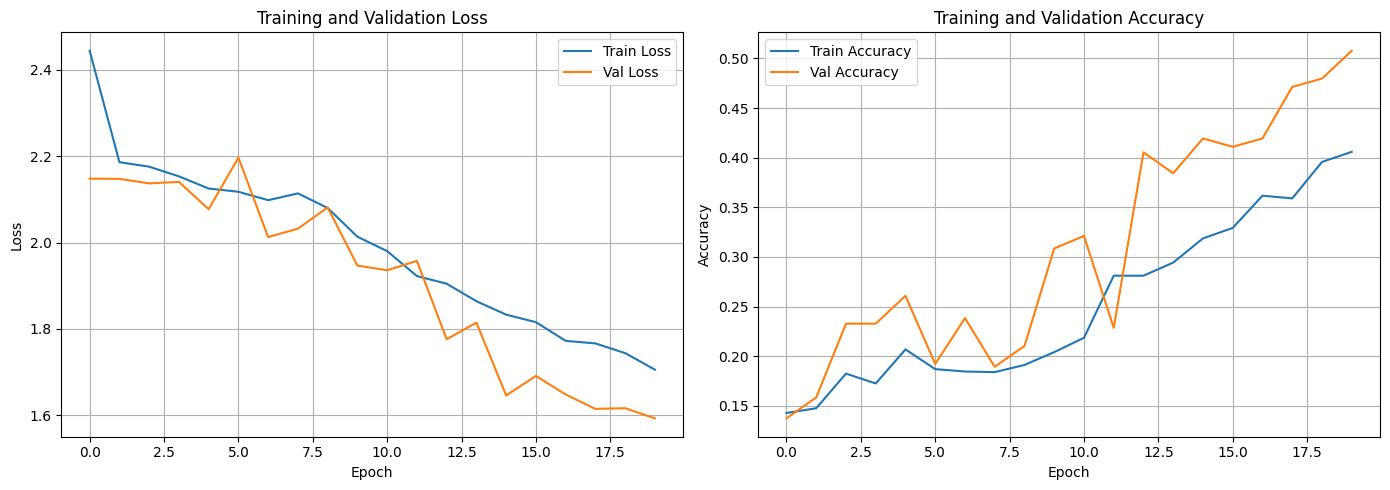


Loaded best model from epoch 20


Testing: 100%|██████████| 45/45 [00:01<00:00, 23.11it/s]



Test Accuracy: 51.75%



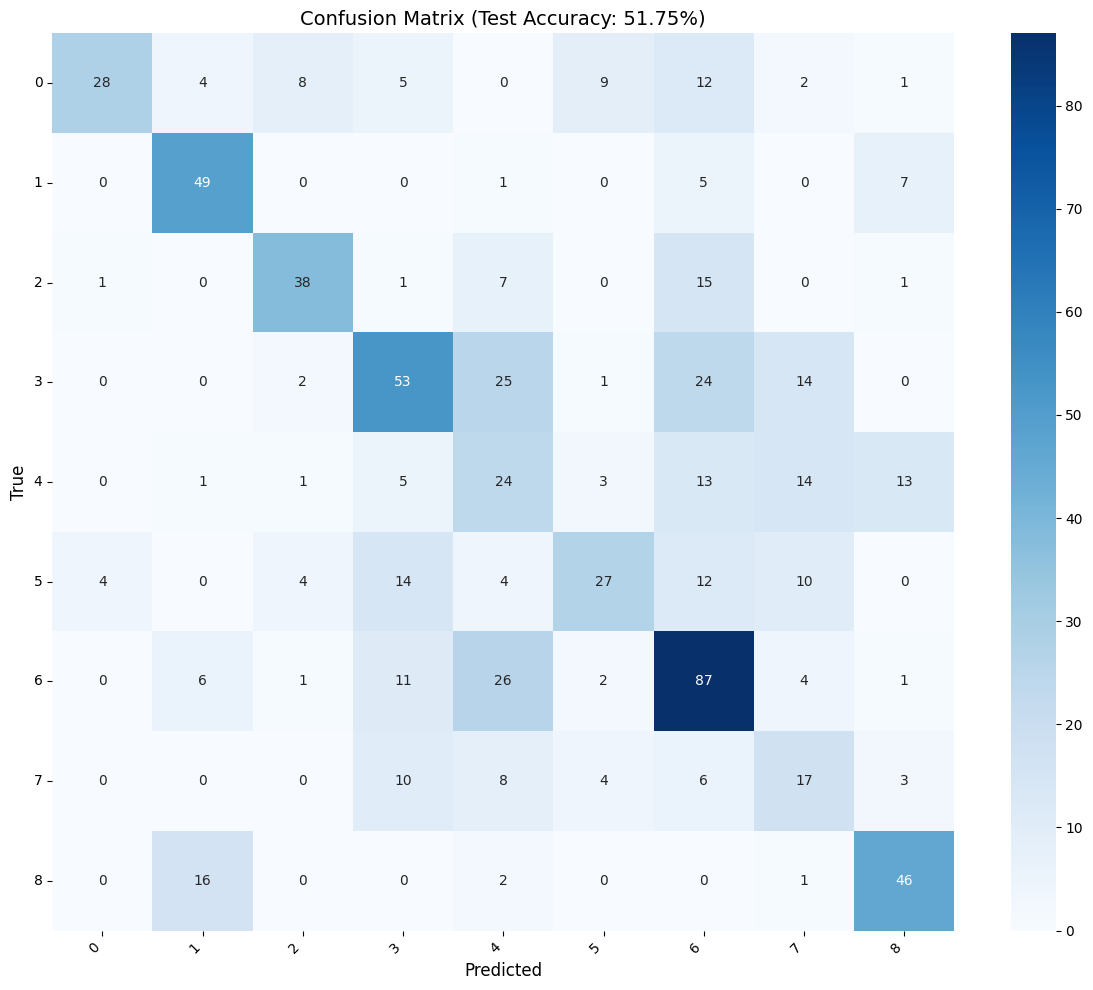


Classification Report:
              precision    recall  f1-score   support

           0     0.8485    0.4058    0.5490        69
           1     0.6447    0.7903    0.7101        62
           2     0.7037    0.6032    0.6496        63
           3     0.5354    0.4454    0.4862       119
           4     0.2474    0.3243    0.2807        74
           5     0.5870    0.3600    0.4463        75
           6     0.5000    0.6304    0.5577       138
           7     0.2742    0.3542    0.3091        48
           8     0.6389    0.7077    0.6715        65

    accuracy                         0.5175       713
   macro avg     0.5533    0.5135    0.5178       713
weighted avg     0.5506    0.5175    0.5195       713


Per-Class Accuracy:
0                   :  40.58% (69 samples)
1                   :  79.03% (62 samples)
2                   :  60.32% (63 samples)
3                   :  44.54% (119 samples)
4                   :  32.43% (74 samples)
5                   :  36.00% (75 

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.15, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=(0.15/0.85), random_state=42, stratify=y[train_idx]
)

print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------

# Compute mean and std from the training dataset
images = np.load("images.npy", allow_pickle=True).astype(np.float32) / 255.0  # scale 0-1
mean = images.mean(axis=(0,1,2))   # per channel mean
std = images.std(axis=(0,1,2))     # per channel std
print("Mean:", mean)
print("Std:", std)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Custom CNN Model
# ---------------------------
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adapt_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.fc1 = nn.Linear(512*4*4, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

print("Using Custom Improved CNN")
model = ImprovedCNN(num_classes, input_channels=3)
model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer and Scheduler
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# ---------------------------
# 7. Training loop
# ---------------------------
num_epochs = 20
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), 
                desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")

Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3326, Val size: 713, Test size: 713
Mean: [0.05387205 0.05387205 0.05387205]
Std: [0.23210354 0.23210354 0.23210354]
Using Residual-style BetterCNN
BetterCNN parameters: 9,026,313

Starting training...


Epoch 1/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.16it/s, acc=0.215, loss=2.06]


Epoch 1/20 | Train Loss: 2.2187 | Train Acc: 0.1855 | Val Loss: 2.0558 | Val Acc: 0.2146
✓ Best model saved with val_acc: 0.2146


Epoch 2/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.04it/s, acc=0.303, loss=1.87]


Epoch 2/20 | Train Loss: 1.9816 | Train Acc: 0.2577 | Val Loss: 1.8692 | Val Acc: 0.3029
✓ Best model saved with val_acc: 0.3029


Epoch 3/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.01it/s, acc=0.358, loss=1.75]


Epoch 3/20 | Train Loss: 1.9081 | Train Acc: 0.3025 | Val Loss: 1.7456 | Val Acc: 0.3576
✓ Best model saved with val_acc: 0.3576


Epoch 4/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 15.71it/s, acc=0.38, loss=1.78] 


Epoch 4/20 | Train Loss: 1.8569 | Train Acc: 0.3473 | Val Loss: 1.7829 | Val Acc: 0.3801
✓ Best model saved with val_acc: 0.3801


Epoch 5/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 15.83it/s, acc=0.431, loss=1.65]


Epoch 5/20 | Train Loss: 1.8278 | Train Acc: 0.3446 | Val Loss: 1.6544 | Val Acc: 0.4306
✓ Best model saved with val_acc: 0.4306


Epoch 6/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 15.68it/s, acc=0.407, loss=1.68]


Epoch 6/20 | Train Loss: 1.8056 | Train Acc: 0.3740 | Val Loss: 1.6826 | Val Acc: 0.4067


Epoch 7/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 15.97it/s, acc=0.518, loss=1.55]


Epoch 7/20 | Train Loss: 1.7658 | Train Acc: 0.3882 | Val Loss: 1.5544 | Val Acc: 0.5175
✓ Best model saved with val_acc: 0.5175


Epoch 8/20 [Val]: 100%|██████████| 45/45 [00:03<00:00, 14.62it/s, acc=0.403, loss=1.67]


Epoch 8/20 | Train Loss: 1.7480 | Train Acc: 0.3903 | Val Loss: 1.6734 | Val Acc: 0.4025


Epoch 9/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.30it/s, acc=0.484, loss=1.62]


Epoch 9/20 | Train Loss: 1.7404 | Train Acc: 0.4098 | Val Loss: 1.6232 | Val Acc: 0.4839


Epoch 10/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.14it/s, acc=0.45, loss=1.61] 


Epoch 10/20 | Train Loss: 1.6988 | Train Acc: 0.4281 | Val Loss: 1.6074 | Val Acc: 0.4502


Epoch 11/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.23it/s, acc=0.349, loss=2.14]


Epoch 11/20 | Train Loss: 1.6658 | Train Acc: 0.4299 | Val Loss: 2.1376 | Val Acc: 0.3492


Epoch 12/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 15.42it/s, acc=0.496, loss=1.56]


Epoch 12/20 | Train Loss: 1.6331 | Train Acc: 0.4606 | Val Loss: 1.5564 | Val Acc: 0.4965


Epoch 13/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.37it/s, acc=0.498, loss=1.52]


Epoch 13/20 | Train Loss: 1.5747 | Train Acc: 0.4838 | Val Loss: 1.5222 | Val Acc: 0.4979


Epoch 14/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.37it/s, acc=0.562, loss=1.44]


Epoch 14/20 | Train Loss: 1.5556 | Train Acc: 0.4714 | Val Loss: 1.4370 | Val Acc: 0.5624
✓ Best model saved with val_acc: 0.5624


Epoch 15/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.05it/s, acc=0.551, loss=1.4] 


Epoch 15/20 | Train Loss: 1.5710 | Train Acc: 0.4898 | Val Loss: 1.3986 | Val Acc: 0.5512


Epoch 16/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.38it/s, acc=0.553, loss=1.43]


Epoch 16/20 | Train Loss: 1.5459 | Train Acc: 0.4952 | Val Loss: 1.4282 | Val Acc: 0.5526


Epoch 17/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.01it/s, acc=0.537, loss=1.53]


Epoch 17/20 | Train Loss: 1.5301 | Train Acc: 0.5054 | Val Loss: 1.5343 | Val Acc: 0.5372


Epoch 18/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.40it/s, acc=0.522, loss=1.5] 


Epoch 18/20 | Train Loss: 1.5097 | Train Acc: 0.5189 | Val Loss: 1.4983 | Val Acc: 0.5217


Epoch 19/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.22it/s, acc=0.595, loss=1.37]


Epoch 19/20 | Train Loss: 1.4894 | Train Acc: 0.5235 | Val Loss: 1.3693 | Val Acc: 0.5947
✓ Best model saved with val_acc: 0.5947


Epoch 20/20 [Val]: 100%|██████████| 45/45 [00:02<00:00, 16.08it/s, acc=0.55, loss=1.54] 


Epoch 20/20 | Train Loss: 1.4663 | Train Acc: 0.5313 | Val Loss: 1.5383 | Val Acc: 0.5498


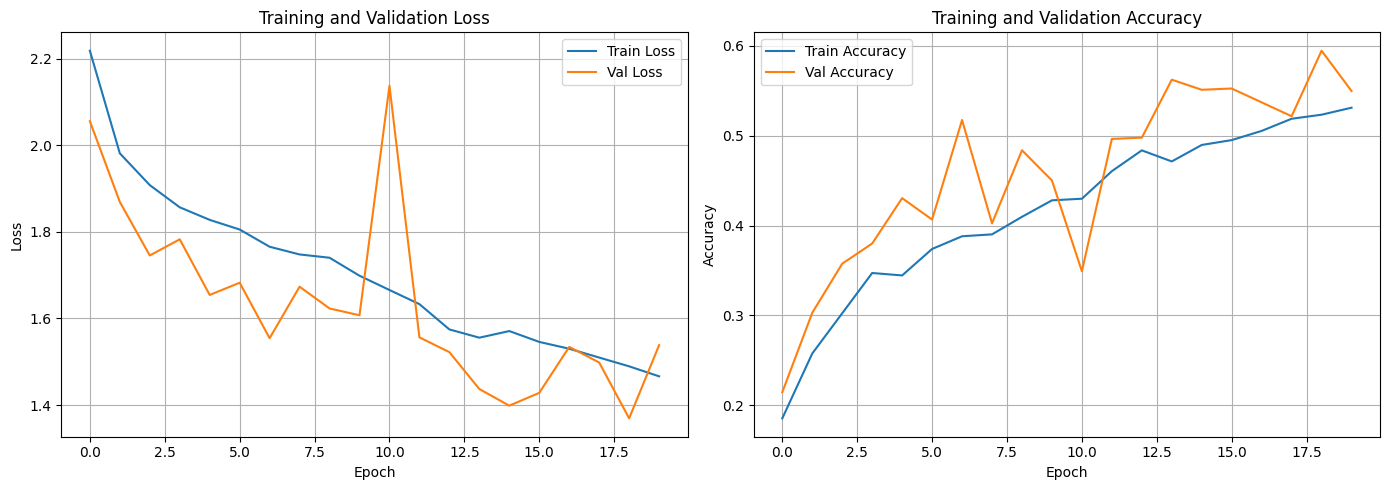


Loaded best model from epoch 19


Testing: 100%|██████████| 45/45 [00:02<00:00, 16.05it/s]



Test Accuracy: 60.31%



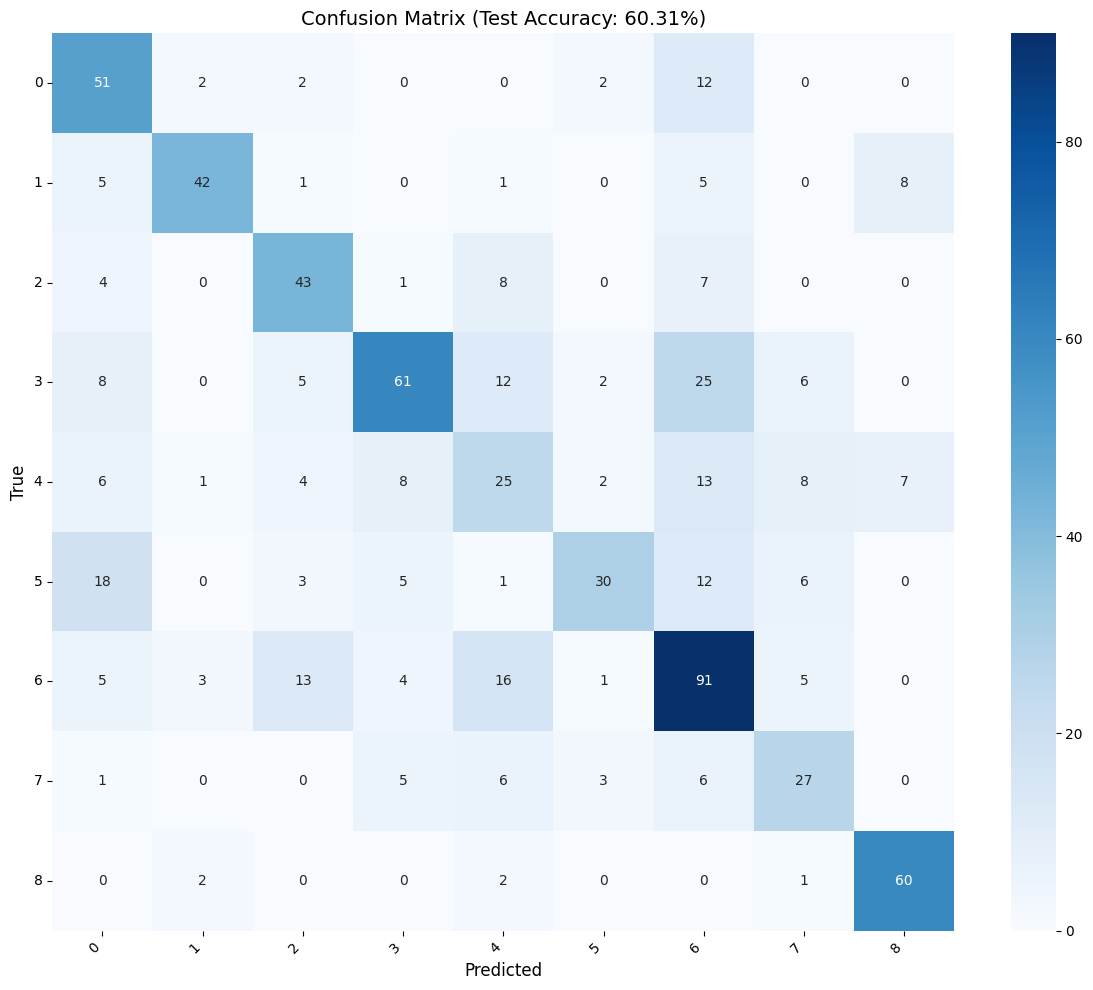


Classification Report:
              precision    recall  f1-score   support

           0     0.5204    0.7391    0.6108        69
           1     0.8400    0.6774    0.7500        62
           2     0.6056    0.6825    0.6418        63
           3     0.7262    0.5126    0.6010       119
           4     0.3521    0.3378    0.3448        74
           5     0.7500    0.4000    0.5217        75
           6     0.5322    0.6594    0.5890       138
           7     0.5094    0.5625    0.5347        48
           8     0.8000    0.9231    0.8571        65

    accuracy                         0.6031       713
   macro avg     0.6262    0.6105    0.6057       713
weighted avg     0.6238    0.6031    0.6001       713


Per-Class Accuracy:
0                   :  73.91% (69 samples)
1                   :  67.74% (62 samples)
2                   :  68.25% (63 samples)
3                   :  51.26% (119 samples)
4                   :  33.78% (74 samples)
5                   :  40.00% (75 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.15, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=(0.15/0.85), random_state=42, stratify=y[train_idx]
)
print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------
images = np.load("images.npy", allow_pickle=True).astype(np.float32) / 255.0
mean = images.mean(axis=(0,1,2))
std = images.std(axis=(0,1,2))
print("Mean:", mean)
print("Std:", std)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Custom Residual-style CNN
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        out = self.relu(out)
        return out

class BetterCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512*4*4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print("Using Residual-style BetterCNN")
model = BetterCNN(num_classes=num_classes, input_channels=3).to(device)
print(f"BetterCNN parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer and Scheduler
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# ---------------------------
# 7. Training loop
# ---------------------------
num_epochs = 20
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")


Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3326, Val size: 713, Test size: 713
Mean: [0.05387205 0.05387205 0.05387205]
Std: [0.23210354 0.23210354 0.23210354]
Using Bigger Residual-style CNN
BigCNN parameters: 28,867,593

Starting training...


Epoch 1/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.84it/s, acc=0.325, loss=2.03]


Epoch 1/20 | Train Loss: 2.8638 | Train Acc: 0.1542 | Val Loss: 2.0289 | Val Acc: 0.3254
✓ Best model saved with val_acc: 0.3254


Epoch 2/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.86it/s, acc=0.177, loss=2.15]


Epoch 2/20 | Train Loss: 2.0967 | Train Acc: 0.2144 | Val Loss: 2.1458 | Val Acc: 0.1767


Epoch 3/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.91it/s, acc=0.337, loss=1.81]


Epoch 3/20 | Train Loss: 2.0115 | Train Acc: 0.2471 | Val Loss: 1.8118 | Val Acc: 0.3366
✓ Best model saved with val_acc: 0.3366


Epoch 4/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.87it/s, acc=0.327, loss=1.87]


Epoch 4/20 | Train Loss: 1.9774 | Train Acc: 0.3013 | Val Loss: 1.8681 | Val Acc: 0.3268


Epoch 5/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.92it/s, acc=0.29, loss=1.81] 


Epoch 5/20 | Train Loss: 1.9265 | Train Acc: 0.3202 | Val Loss: 1.8100 | Val Acc: 0.2903


Epoch 6/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.74it/s, acc=0.398, loss=1.67]


Epoch 6/20 | Train Loss: 1.8372 | Train Acc: 0.3440 | Val Loss: 1.6742 | Val Acc: 0.3983
✓ Best model saved with val_acc: 0.3983


Epoch 7/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.87it/s, acc=0.415, loss=1.67]


Epoch 7/20 | Train Loss: 1.8048 | Train Acc: 0.3677 | Val Loss: 1.6674 | Val Acc: 0.4151
✓ Best model saved with val_acc: 0.4151


Epoch 8/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.79it/s, acc=0.376, loss=1.88]


Epoch 8/20 | Train Loss: 1.7432 | Train Acc: 0.3960 | Val Loss: 1.8846 | Val Acc: 0.3759


Epoch 9/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.74it/s, acc=0.447, loss=1.55]


Epoch 9/20 | Train Loss: 1.7176 | Train Acc: 0.4161 | Val Loss: 1.5529 | Val Acc: 0.4474
✓ Best model saved with val_acc: 0.4474


Epoch 10/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.82it/s, acc=0.463, loss=1.62]


Epoch 10/20 | Train Loss: 1.6927 | Train Acc: 0.4287 | Val Loss: 1.6226 | Val Acc: 0.4628
✓ Best model saved with val_acc: 0.4628


Epoch 11/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.90it/s, acc=0.415, loss=1.77]


Epoch 11/20 | Train Loss: 1.6634 | Train Acc: 0.4504 | Val Loss: 1.7669 | Val Acc: 0.4151


Epoch 12/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.89it/s, acc=0.56, loss=1.4]  


Epoch 12/20 | Train Loss: 1.6466 | Train Acc: 0.4459 | Val Loss: 1.4033 | Val Acc: 0.5596
✓ Best model saved with val_acc: 0.5596


Epoch 13/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.93it/s, acc=0.544, loss=1.5] 


Epoch 13/20 | Train Loss: 1.6222 | Train Acc: 0.4540 | Val Loss: 1.4985 | Val Acc: 0.5442


Epoch 14/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.79it/s, acc=0.548, loss=1.43]


Epoch 14/20 | Train Loss: 1.5676 | Train Acc: 0.4741 | Val Loss: 1.4343 | Val Acc: 0.5484


Epoch 15/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.84it/s, acc=0.435, loss=2.01]


Epoch 15/20 | Train Loss: 1.5664 | Train Acc: 0.4889 | Val Loss: 2.0117 | Val Acc: 0.4348


Epoch 16/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.90it/s, acc=0.464, loss=1.69]


Epoch 16/20 | Train Loss: 1.5653 | Train Acc: 0.4922 | Val Loss: 1.6908 | Val Acc: 0.4642


Epoch 17/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.92it/s, acc=0.597, loss=1.37]


Epoch 17/20 | Train Loss: 1.4678 | Train Acc: 0.5310 | Val Loss: 1.3718 | Val Acc: 0.5975
✓ Best model saved with val_acc: 0.5975


Epoch 18/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.88it/s, acc=0.589, loss=1.39]


Epoch 18/20 | Train Loss: 1.4564 | Train Acc: 0.5343 | Val Loss: 1.3868 | Val Acc: 0.5891


Epoch 19/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.91it/s, acc=0.568, loss=1.45]


Epoch 19/20 | Train Loss: 1.4557 | Train Acc: 0.5355 | Val Loss: 1.4526 | Val Acc: 0.5680


Epoch 20/20 [Val]: 100%|██████████| 45/45 [00:05<00:00,  8.83it/s, acc=0.586, loss=1.35]


Epoch 20/20 | Train Loss: 1.4065 | Train Acc: 0.5496 | Val Loss: 1.3488 | Val Acc: 0.5863


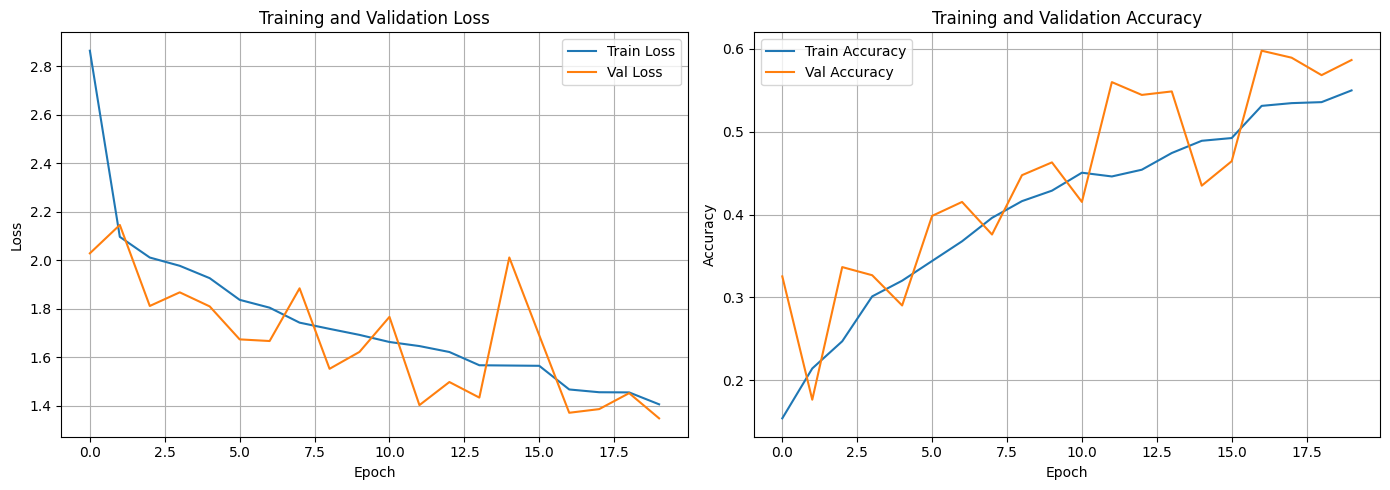


Loaded best model from epoch 17


Testing: 100%|██████████| 45/45 [00:05<00:00,  8.76it/s]



Test Accuracy: 62.69%



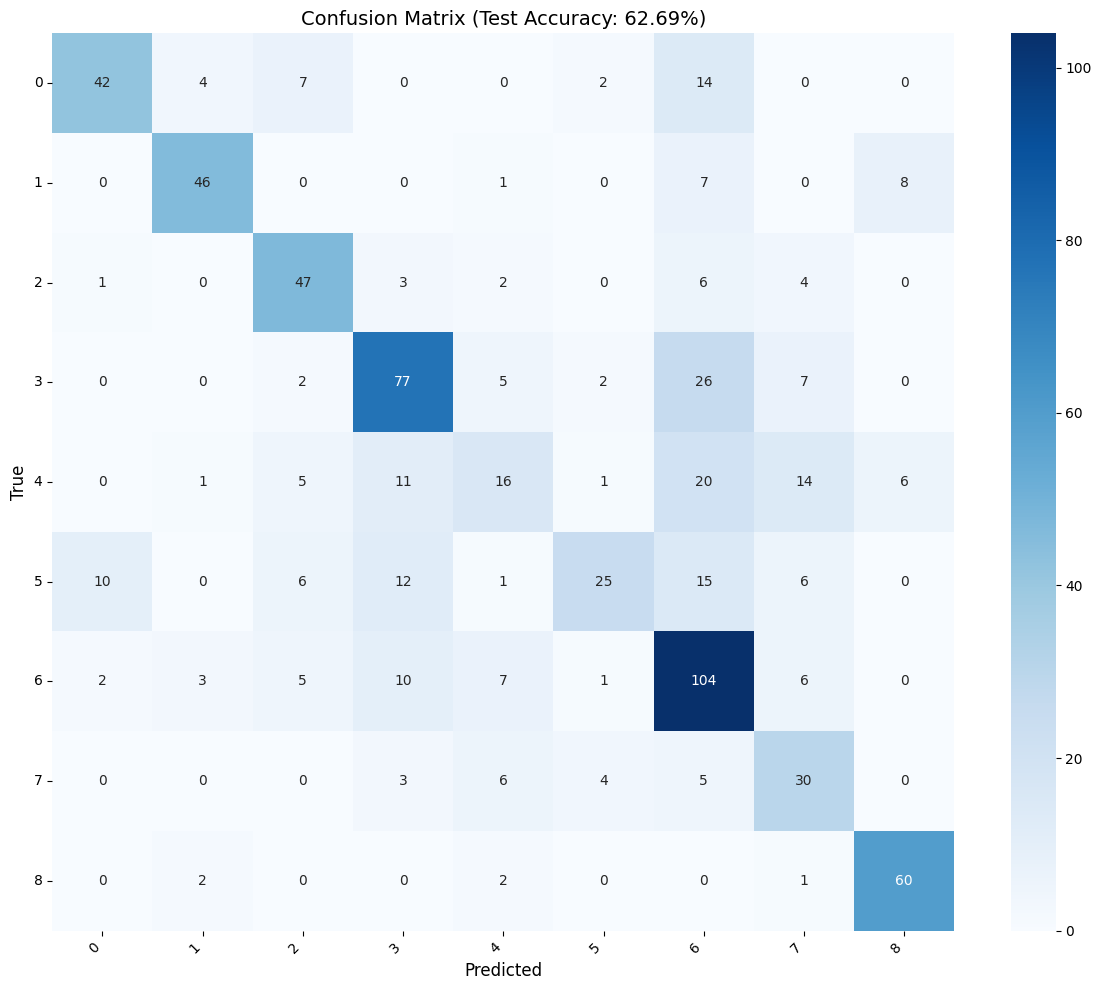


Classification Report:
              precision    recall  f1-score   support

           0     0.7636    0.6087    0.6774        69
           1     0.8214    0.7419    0.7797        62
           2     0.6528    0.7460    0.6963        63
           3     0.6638    0.6471    0.6553       119
           4     0.4000    0.2162    0.2807        74
           5     0.7143    0.3333    0.4545        75
           6     0.5279    0.7536    0.6209       138
           7     0.4412    0.6250    0.5172        48
           8     0.8108    0.9231    0.8633        65

    accuracy                         0.6269       713
   macro avg     0.6440    0.6217    0.6162       713
weighted avg     0.6362    0.6269    0.6149       713


Per-Class Accuracy:
0                   :  60.87% (69 samples)
1                   :  74.19% (62 samples)
2                   :  74.60% (63 samples)
3                   :  64.71% (119 samples)
4                   :  21.62% (74 samples)
5                   :  33.33% (75 

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.15, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=(0.15/0.85), random_state=42, stratify=y[train_idx]
)
print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------
images = np.load("images.npy", allow_pickle=True).astype(np.float32) / 255.0
mean = images.mean(axis=(0,1,2))
std = images.std(axis=(0,1,2))
print("Mean:", mean)
print("Std:", std)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Bigger Residual-style CNN
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        out = self.relu(out)
        return out

class BigCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )
        self.layer5 = nn.Sequential(
            ResidualBlock(512, 512),
            ResidualBlock(512, 512)
        )
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print("Using Bigger Residual-style CNN")
model = BigCNN(num_classes=num_classes, input_channels=3).to(device)
print(f"BigCNN parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer and Scheduler
# ---------------------------
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# ---------------------------
# 7. Training loop
# ---------------------------
num_epochs = 20
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 0. Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# 1. Load data
# ---------------------------
image_array = np.load("images.npy", allow_pickle=True)
labels = np.load("labels.npy", allow_pickle=True)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")
print(f"Class distribution: {np.bincount(y)}")

# Train/Val/Test split
train_idx, test_idx = train_test_split(
    np.arange(len(y)), test_size=0.15, random_state=42, stratify=y
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=(0.15/0.85), random_state=42, stratify=y[train_idx]
)
print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}, Test size: {len(test_idx)}")

# ---------------------------
# 2. Dataset class
# ---------------------------
class WasteDataset(Dataset):
    def __init__(self, images, labels, indices, transform=None):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        img = self.images[i].astype(np.uint8)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 3. Enhanced Transforms
# ---------------------------
images = np.load("images.npy", allow_pickle=True).astype(np.float32) / 255.0
mean = images.mean(axis=(0,1,2))
std = images.std(axis=(0,1,2))
print("Mean:", mean)
print("Std:", std)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(image_array, y, train_idx, transform=train_transform)
val_dataset = WasteDataset(image_array, y, val_idx, transform=val_transform)
test_dataset = WasteDataset(image_array, y, test_idx, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=0, pin_memory=True)

# ---------------------------
# 4. Improved Residual CNN with SE Attention
# ---------------------------
class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.use_se = use_se
        if use_se:
            self.se = SEBlock(out_channels)
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.use_se:
            out = self.se(out)
        
        out += self.skip(x)
        out = self.relu(out)
        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super().__init__()
        # Initial layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        
        # Block 2: 64 -> 128 (3 residual blocks)
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2, use_se=True),
            ResidualBlock(128, 128, use_se=False),
            ResidualBlock(128, 128, use_se=True)
        )
        
        # Block 3: 128 -> 256 (4 residual blocks)
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2, use_se=True),
            ResidualBlock(256, 256, use_se=False),
            ResidualBlock(256, 256, use_se=True),
            ResidualBlock(256, 256, use_se=False)
        )
        
        # Block 4: 256 -> 512 (4 residual blocks)
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2, use_se=True),
            ResidualBlock(512, 512, use_se=True),
            ResidualBlock(512, 512, use_se=False),
            ResidualBlock(512, 512, use_se=True)
        )
        
        # Block 5: 512 -> 512 (3 residual blocks)
        self.layer5 = nn.Sequential(
            ResidualBlock(512, 512, use_se=True),
            ResidualBlock(512, 512, use_se=True),
            ResidualBlock(512, 512, use_se=True)
        )
        
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        
        # Enhanced classifier
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 2, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        # Dual pooling
        x_avg = self.global_avg_pool(x).view(x.size(0), -1)
        x_max = self.global_max_pool(x).view(x.size(0), -1)
        x = torch.cat([x_avg, x_max], dim=1)
        
        # Classifier
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

print("Using Improved Residual CNN with SE Attention")
model = ImprovedCNN(num_classes=num_classes, input_channels=3).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# 5. Label Smoothing Loss
# ---------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
    
    def forward(self, output, target):
        n_class = output.size(1)
        log_preds = F.log_softmax(output, dim=1)
        loss = -log_preds.sum(dim=1).mean()
        nll = F.nll_loss(log_preds, target, weight=self.weight)
        return (1 - self.epsilon) * nll + self.epsilon * loss / n_class

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y[train_idx]),
    y=y[train_idx]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights)

# ---------------------------
# 6. Optimizer and Scheduler
# ---------------------------
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-7
)

# ---------------------------
# 7. Training loop
# ---------------------------
num_epochs = 20
best_val_acc = 0
patience = 10
trigger_times = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for i, (X_batch, y_batch) in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        loop.set_postfix(loss=running_loss/total, acc=correct/total)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    with torch.no_grad():
        for X_batch, y_batch in loop_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            loop_val.set_postfix(loss=val_loss/total, acc=correct/total)

    val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, "best_model.pth")
        print(f"✓ Best model saved with val_acc: {val_acc:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

# ---------------------------
# 8. Plot training history
# ---------------------------
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 9. Test evaluation
# ---------------------------
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")

model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    loop_test = tqdm(test_loader, desc="Testing")
    for X_batch, y_batch in loop_test:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

test_acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*50}\n")

# ---------------------------
# 10. Confusion matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title(f"Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------
# 11. Classification report
# ---------------------------
print("\nClassification Report:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=[str(c) for c in encoder.classes_], digits=4))

# ---------------------------
# 12. Per-class accuracy
# ---------------------------
print("\nPer-Class Accuracy:")
print("="*70)
for i, class_name in enumerate(encoder.classes_):
    class_mask = np.array(y_true) == i
    if class_mask.sum() > 0:
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        print(f"{str(class_name):20s}: {class_acc*100:6.2f}% ({class_mask.sum()} samples)")

print("\n✓ Training complete!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Final test accuracy: {test_acc*100:.2f}%")

Using device: cuda
Number of classes: 9
Classes: [0 1 2 3 4 5 6 7 8]
Class distribution: [461 411 420 790 495 500 921 318 436]
Train size: 3326, Val size: 713, Test size: 713
Mean: [0.05387205 0.05387205 0.05387205]
Std: [0.23210354 0.23210354 0.23210354]
Using MASSIVE Custom CNN from Scratch (30+ layers)
MegaCNN parameters: 200,360,591

Starting training...


Epoch 1/30 [Val]: 100%|██████████| 45/45 [00:05<00:00,  7.70it/s, acc=0.0968, loss=2.43]


Epoch 1/30 | Train Loss: 2.3958 | Train Acc: 0.1152 | Val Loss: 2.4261 | Val Acc: 0.0968
✓ Best model saved with val_acc: 0.0968


Epoch 2/30 [Val]: 100%|██████████| 45/45 [00:05<00:00,  7.73it/s, acc=0.105, loss=2.22] 


Epoch 2/30 | Train Loss: 2.3303 | Train Acc: 0.1115 | Val Loss: 2.2189 | Val Acc: 0.1052
✓ Best model saved with val_acc: 0.1052


Epoch 3/30 [Val]: 100%|██████████| 45/45 [00:05<00:00,  7.72it/s, acc=0.0561, loss=2.29]


Epoch 3/30 | Train Loss: 2.3087 | Train Acc: 0.1067 | Val Loss: 2.2935 | Val Acc: 0.0561


Epoch 4/30 [Val]: 100%|██████████| 45/45 [00:06<00:00,  7.40it/s, acc=0.144, loss=2.21]


Epoch 4/30 | Train Loss: 2.3031 | Train Acc: 0.1137 | Val Loss: 2.2096 | Val Acc: 0.1445
✓ Best model saved with val_acc: 0.1445


Epoch 5/30 [Val]: 100%|██████████| 45/45 [00:06<00:00,  7.29it/s, acc=0.125, loss=2.28]


Epoch 5/30 | Train Loss: 2.3062 | Train Acc: 0.0959 | Val Loss: 2.2799 | Val Acc: 0.1248


Epoch 6/30 [Val]: 100%|██████████| 45/45 [00:05<00:00,  7.64it/s, acc=0.151, loss=2.68]


Epoch 6/30 | Train Loss: 2.2656 | Train Acc: 0.1200 | Val Loss: 2.6833 | Val Acc: 0.1515
✓ Best model saved with val_acc: 0.1515


Epoch 7/30 [Val]: 100%|██████████| 45/45 [00:05<00:00,  7.66it/s, acc=0.128, loss=2.19]


Epoch 7/30 | Train Loss: 2.2566 | Train Acc: 0.1299 | Val Loss: 2.1933 | Val Acc: 0.1276


Epoch 8/30 [Train]:  15%|█▍        | 31/208 [00:14<01:20,  2.19it/s, acc=0.123, loss=2.28]


KeyboardInterrupt: 